In [8]:
import plotly as py
import plotly.offline as po
import plotly.graph_objs as go
import ipywidgets as widegets
from scipy import special

py.offline.init_notebook_mode(connected=True)

In [9]:

import numpy as np
import pandas as pd 
import datetime 
import time 
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from pylab import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
plt.rcParams["figure.figsize"] = [9,5]
sns.set(rc={'figure.figsize':(6,3)})

In [10]:
cab_df=pd.read_csv('cab_rides.csv')
weather_df=pd.read_csv('weather.csv')
pd.set_option('display.max_columns', 500)

## Converting UNIX Date to DatetimeNS format

In [11]:
cab_df['date_time_ns'] = pd.to_datetime(cab_df['time_stamp']/1000, unit='s')
weather_df['date_time_ns'] = pd.to_datetime(weather_df['time_stamp'], unit='s')


In [12]:
weather_df['date_time_ns'].min()

Timestamp('2018-11-26 03:40:44')

In [13]:
weather_df['date_time_ns'].max()

Timestamp('2018-12-18 18:45:02')

In [14]:
cab_df['date_time_ns'].min()

Timestamp('2018-11-26 03:40:46.318000078')

### Defining Functions

In [15]:

def zscore(series):
    return (series - series.mean())/series.std()

def mean(series):
    return series.sum()/series.count()

def log_function(series):
    return np.log(series)

### Preprocessing datasets in order to merge them

### Creating a Primary Key taking (Location, Date & Time) from respective datasets

In [16]:
cab_df['merge_col'] = cab_df.source.astype(str) +" - "+ cab_df.date_time_ns.dt.date.astype("str") +" - "+ cab_df.date_time_ns.dt.hour.astype("str")

In [17]:
weather_df['merge_col'] = weather_df.location.astype(str) +" - "+ weather_df.date_time_ns.dt.date.astype("str") +" - "+ weather_df.date_time_ns.dt.hour.astype("str")

In [18]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   temp          6276 non-null   float64       
 1   location      6276 non-null   object        
 2   clouds        6276 non-null   float64       
 3   pressure      6276 non-null   float64       
 4   rain          894 non-null    float64       
 5   time_stamp    6276 non-null   int64         
 6   humidity      6276 non-null   float64       
 7   wind          6276 non-null   float64       
 8   date_time_ns  6276 non-null   datetime64[ns]
 9   merge_col     6276 non-null   object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 490.4+ KB


In [19]:
weather_df.index = weather_df['merge_col']

In [20]:
weather_df['merge_col'].nunique()

3960

In [21]:
duplicateRowsDF = weather_df.drop_duplicates(keep='last', subset='merge_col', inplace=True)

In [22]:
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)

Duplicate Rows except first occurrence based on all columns are :
None


In [23]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3960 entries, Back Bay - 2018-12-16 - 23 to West End - 2018-12-03 - 6
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   temp          3960 non-null   float64       
 1   location      3960 non-null   object        
 2   clouds        3960 non-null   float64       
 3   pressure      3960 non-null   float64       
 4   rain          529 non-null    float64       
 5   time_stamp    3960 non-null   int64         
 6   humidity      3960 non-null   float64       
 7   wind          3960 non-null   float64       
 8   date_time_ns  3960 non-null   datetime64[ns]
 9   merge_col     3960 non-null   object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 340.3+ KB


In [24]:
merged_df = cab_df.join(weather_df,on=['merge_col'],rsuffix ='_w')

In [25]:
merged_df.count()

distance            693071
cab_type            693071
time_stamp          693071
destination         693071
source              693071
price               637976
surge_multiplier    693071
id                  693071
product_id          693071
name                693071
date_time_ns        693071
merge_col           693071
temp                690107
location            690107
clouds              690107
pressure            690107
rain                104620
time_stamp_w        690107
humidity            690107
wind                690107
date_time_ns_w      690107
merge_col_w         690107
dtype: int64

## Filling 0 for missing values for 'Rain' (Missing Data at Random)

In [26]:
merged_df['rain'].fillna(0,inplace=True)

As observing from the Null value plot, looks like we received some redundancies while merging the datasets on the primary key. We can dop 

In [27]:
merged_df = merged_df[pd.notnull(merged_df['date_time_ns_w'])]

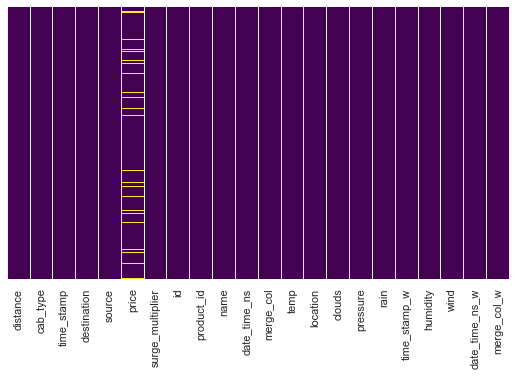

In [28]:
plt.figure(figsize=(9,5))
sns.heatmap(merged_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [29]:
merged_df.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'date_time_ns',
       'merge_col', 'temp', 'location', 'clouds', 'pressure', 'rain',
       'time_stamp_w', 'humidity', 'wind', 'date_time_ns_w', 'merge_col_w'],
      dtype='object')

In [30]:
print(merged_df['cab_type'].value_counts(normalize=True))

Uber    0.556443
Lyft    0.443557
Name: cab_type, dtype: float64


### Fetching | 'Hour' | 'Day of Week' | 'Month' | 'Day in Month' | from Time Stamp of the cab bookings

In [31]:
merged_df['hour'] = merged_df.date_time_ns.dt.hour
merged_df['dayofweek'] = merged_df.date_time_ns.dt.dayofweek
merged_df['dayofmonth'] = merged_df.date_time_ns.dt.day

In [32]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690107 entries, 0 to 693070
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   distance          690107 non-null  float64       
 1   cab_type          690107 non-null  object        
 2   time_stamp        690107 non-null  int64         
 3   destination       690107 non-null  object        
 4   source            690107 non-null  object        
 5   price             635242 non-null  float64       
 6   surge_multiplier  690107 non-null  float64       
 7   id                690107 non-null  object        
 8   product_id        690107 non-null  object        
 9   name              690107 non-null  object        
 10  date_time_ns      690107 non-null  datetime64[ns]
 11  merge_col         690107 non-null  object        
 12  temp              690107 non-null  float64       
 13  location          690107 non-null  object        
 14  clou

In [33]:
merged_df.set_index('date_time_ns_w')

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time_ns,merge_col,temp,location,clouds,pressure,rain,time_stamp_w,humidity,wind,merge_col_w,hour,dayofweek,dayofmonth
date_time_ns_w,,,,,,,,,,,,,,,,,,,,,,,,
2018-12-16 09:45:01,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890000105,Haymarket Square - 2018-12-16 - 9,38.46,Haymarket Square,0.29,1022.25,0.0000,1.544954e+09,0.76,7.68,Haymarket Square - 2018-12-16 - 9,9,6,16
2018-11-27 02:45:20,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.677000046,Haymarket Square - 2018-11-27 - 2,43.82,Haymarket Square,0.99,1002.59,0.0997,1.543287e+09,0.89,11.57,Haymarket Square - 2018-11-27 - 2,2,1,27
2018-11-30 04:52:54,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749000072,Haymarket Square - 2018-11-30 - 4,35.08,Haymarket Square,0.00,1013.71,0.0000,1.543554e+09,0.70,5.25,Haymarket Square - 2018-11-30 - 4,4,4,30
2018-11-29 03:19:00,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223000050,Haymarket Square - 2018-11-29 - 3,37.66,Haymarket Square,0.41,998.42,0.0000,1.543462e+09,0.71,11.16,Haymarket Square - 2018-11-29 - 3,3,3,29
2018-12-17 18:45:01,0.44,Lyft,1545071112138,North Station,Haymarket Square,16.5,1.0,f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2,lyft_lux,Lux Black,2018-12-17 18:25:12.138000011,Haymarket Square - 2018-12-17 - 18,40.78,Haymarket Square,0.93,1000.15,0.0000,1.545072e+09,0.79,7.55,Haymarket Square - 2018-12-17 - 18,18,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-01 23:52:55,1.00,Uber,1543708385534,North End,West End,13.0,1.0,616d3611-1820-450a-9845-a9ff304a4842,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-12-01 23:53:05.533999919,West End - 2018-12-01 - 23,36.69,West End,0.41,1023.64,0.0000,1.543708e+09,0.76,2.51,West End - 2018-12-01 - 23,23,5,1
2018-12-01 23:52:55,1.00,Uber,1543708385534,North End,West End,9.5,1.0,633a3fc3-1f86-4b9e-9d48-2b7132112341,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-12-01 23:53:05.533999919,West End - 2018-12-01 - 23,36.69,West End,0.41,1023.64,0.0000,1.543708e+09,0.76,2.51,West End - 2018-12-01 - 23,23,5,1
2018-12-01 23:52:55,1.00,Uber,1543708385534,North End,West End,NaN,1.0,64d451d0-639f-47a4-9b7c-6fd92fbd264f,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,2018-12-01 23:53:05.533999919,West End - 2018-12-01 - 23,36.69,West End,0.41,1023.64,0.0000,1.543708e+09,0.76,2.51,West End - 2018-12-01 - 23,23,5,1


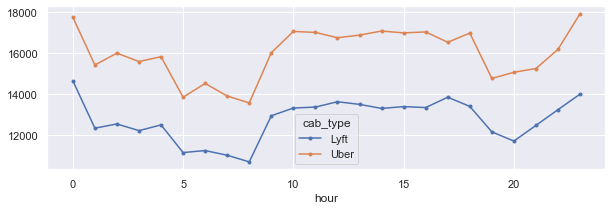

In [34]:
plt.rcParams["figure.figsize"] = [10,3]

merged_df.groupby(['hour', 'cab_type'])['id'].count().unstack().plot(kind='line', marker='.')
plt.show()

In [35]:

merged_df_peak=merged_df.copy()

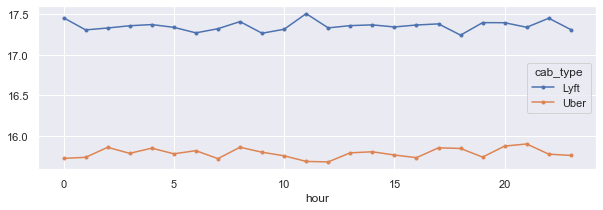

In [36]:
plt.rcParams["figure.figsize"] = [10,3]

merged_df.groupby(['hour', 'cab_type'])['price'].mean().unstack().plot(kind='line', marker='.')
plt.show()

In [37]:
fig = px.histogram(merged_df, x='hour', y='price', color='cab_type',histfunc='avg', barmode='group')
po.plot(fig, filename = 'price vs hour.html_avg', auto_open=False)

/Applications/anaconda3/lib/python3.7/site-packages/plotly/offline/offline.py:563: UserWarning:

Your filename `price vs hour.html_avg` didn't end with .html. Adding .html to the end of your file.



'price vs hour.html_avg.html'

In [38]:
fig = px.histogram(merged_df, x='hour', y='price', color='cab_type',histfunc='max', barmode='group')

po.plot(fig, filename = 'price vs hour_max.html', auto_open=False)

'price vs hour_max.html'

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


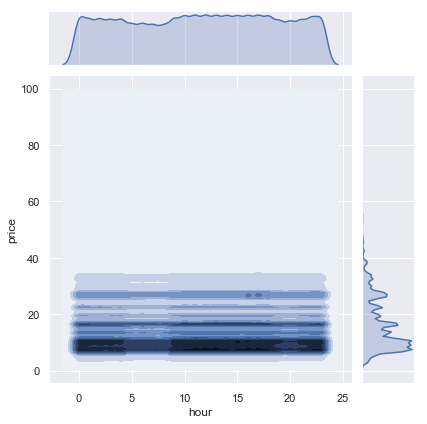

In [27]:
sns.jointplot(x='hour',y='price', data=merged_df, kind='kde')

In [41]:
merged_df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time_ns,merge_col,temp,location,clouds,pressure,rain,time_stamp_w,humidity,wind,date_time_ns_w,merge_col_w,hour,dayofweek,dayofmonth
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890000105,Haymarket Square - 2018-12-16 - 9,38.46,Haymarket Square,0.29,1022.25,0.0000,1.544954e+09,0.76,7.68,2018-12-16 09:45:01,Haymarket Square - 2018-12-16 - 9,9,6,16
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.677000046,Haymarket Square - 2018-11-27 - 2,43.82,Haymarket Square,0.99,1002.59,0.0997,1.543287e+09,0.89,11.57,2018-11-27 02:45:20,Haymarket Square - 2018-11-27 - 2,2,1,27
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749000072,Haymarket Square - 2018-11-30 - 4,35.08,Haymarket Square,0.00,1013.71,0.0000,1.543554e+09,0.70,5.25,2018-11-30 04:52:54,Haymarket Square - 2018-11-30 - 4,4,4,30
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223000050,Haymarket Square - 2018-11-29 - 3,37.66,Haymarket Square,0.41,998.42,0.0000,1.543462e+09,0.71,11.16,2018-11-29 03:19:00,Haymarket Square - 2018-11-29 - 3,3,3,29
5,0.44,Lyft,1545071112138,North Station,Haymarket Square,16.5,1.0,f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2,lyft_lux,Lux Black,2018-12-17 18:25:12.138000011,Haymarket Square - 2018-12-17 - 18,40.78,Haymarket Square,0.93,1000.15,0.0000,1.545072e+09,0.79,7.55,2018-12-17 18:45:01,Haymarket Square - 2018-12-17 - 18,18,0,17


In [39]:
merged_df['highsurge']=merged_df['surge_multiplier'].apply(lambda x:'Yes' if x>1 else 'No')

In [40]:
fig=px.scatter(merged_df.sort_values(by=['hour']), x='hour', y='price', 
               color='highsurge', marginal_y='box', marginal_x='histogram')
po.plot(fig, filename = 'price vs hour.html', auto_open=False)

'price vs hour.html'

In [41]:
fig=px.scatter(merged_df.sort_values(by=['dayofweek']), x='dayofweek', y='price', 
               color='highsurge', marginal_y='box', marginal_x='histogram', trendline='ols')
po.plot(fig, filename = 'price vs day.html', auto_open=False)

'price vs day.html'

In [42]:
fig=px.scatter_3d(merged_df.sort_values(by=['hour']), x='hour', y='price', z='dayofweek'
               , color='highsurge')
po.plot(fig, filename = 'price vs hour vs day.html', auto_open=False)

'price vs hour vs day.html'

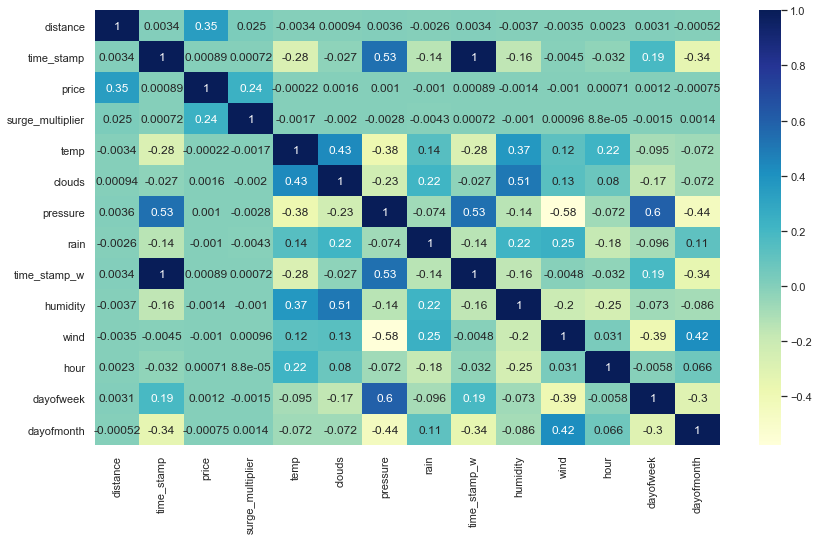

In [43]:
plt.rcParams["figure.figsize"] = [14,8]
cab_corr = merged_df.corr()
sns.heatmap(cab_corr, cmap='YlGnBu', annot=True)
plt.show()

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


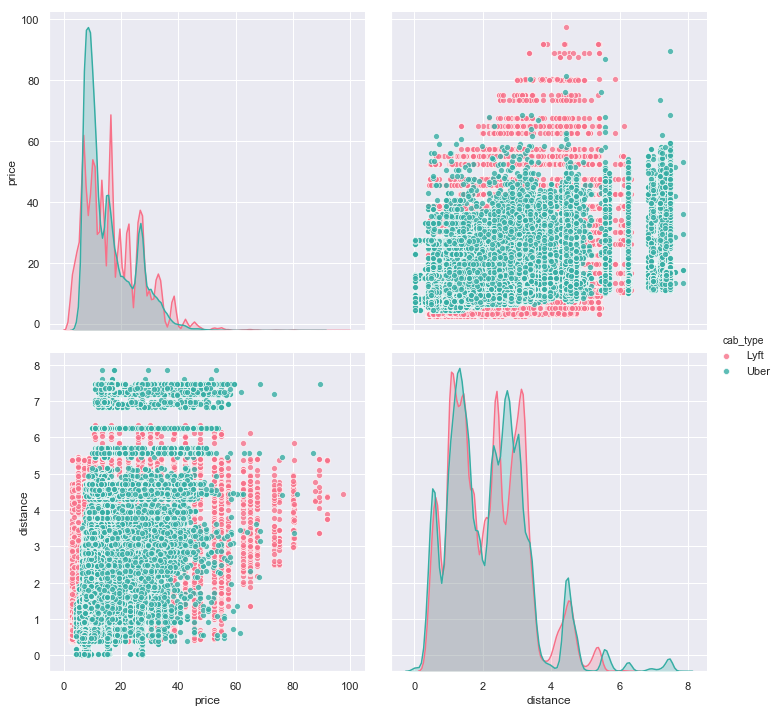

In [29]:
sns.pairplot(merged_df, 
            vars=['price', 'distance'],
            hue='cab_type', 
            palette='husl',
            plot_kws={'alpha':0.8},
            size=5)
plt.show()

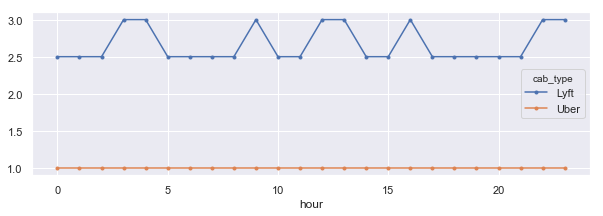

In [30]:
plt.rcParams["figure.figsize"] = [10,3]
df_check = merged_df.loc['2018-11-26':'2018-12-18', :]
merged_df.groupby(['hour', 'cab_type'])['surge_multiplier'].max().unstack().plot(kind='line', marker='.')
plt.show()

In [44]:
merged_df[merged_df['cab_type']=='Uber'].groupby('hour')['surge_multiplier'].agg(np.max).max()

1.0

In [45]:
merged_df_lyft = merged_df[merged_df.loc[:,'cab_type']=='Lyft']

In [46]:
merged_df_null=merged_df[merged_df['price'].isnull()]

In [47]:
merged_df_notnull=merged_df[merged_df['price'].notnull()]
merged_df_notnull.set_index('date_time_ns_w', inplace=True)

In [48]:
merged_df_notnull.drop(columns=['time_stamp_w','time_stamp','date_time_ns'], axis=1, inplace=True)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



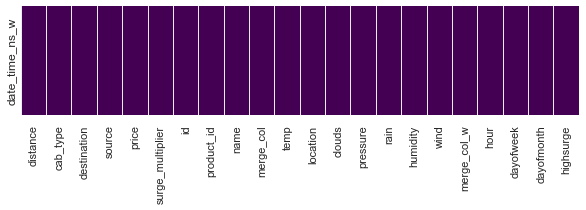

In [49]:
plt.figure(figsize=(10,2))
sns.heatmap(merged_df_notnull.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
plt.rcParams["figure.figsize"] = [16,9]
sns.set(rc={'figure.figsize':(16,9)})
sns.swarmplot(x='cab_type', y='price', data=merged_df_notnull, hue='hour',size=10)
plt.show()

In [126]:
merged_df_notnull['cab_type'].dtype

dtype('O')

In [127]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [128]:
le_dict = {}
for col in merged_df_notnull.dtypes[merged_df_notnull.dtypes=="object"].index:
    print(col)
    le_dict[col] = preprocessing.LabelEncoder()
    merged_df_notnull[col] = le_dict[col].fit_transform(merged_df_notnull[col].astype(str))

cab_type


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



destination
source
id
product_id
name
merge_col
location
merge_col_w
highsurge


In [129]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(merged_df_notnull)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



StandardScaler(copy=True, with_mean=True, with_std=True)

In [130]:
scaled_features=scaler.transform(merged_df_notnull)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



In [131]:
scaled_df = pd.DataFrame(scaled_features)
scaled_df.columns = merged_df_notnull.columns
scaled_df.head()

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,merge_col,temp,location,clouds,pressure,rain,humidity,wind,merge_col_w,hour,dayofweek,dayofmonth,highsurge
0,-1.540418,-1.036949,0.435917,-0.143731,-1.238188,-0.157886,-0.835531,0.466207,0.418953,-0.025665,-0.112370,-0.143731,-1.221539,0.898246,-0.219197,0.088816,0.200086,-0.025665,-0.379577,1.560271,-0.182121,-0.184372
1,-1.540418,-1.036949,0.435917,-0.143731,-0.594644,-0.157886,-0.706901,1.625501,-1.012204,-0.246878,0.698357,-0.143731,1.007780,-0.570490,3.272252,1.095338,1.261488,-0.246878,-1.387386,-0.868717,0.920506,-0.184372
2,-1.540418,-1.036949,0.435917,-0.143731,1.014217,-0.157886,0.903211,1.045854,-0.439741,-0.183674,-0.623612,-0.143731,-2.145115,0.260250,-0.219197,-0.375733,-0.462949,-0.183674,-1.099440,0.588676,1.221222,-0.184372
3,-1.540418,-1.036949,0.435917,-0.143731,-0.809159,-0.157886,1.299348,1.335678,0.132722,-0.205620,-0.233374,-0.143731,-0.839370,-0.882018,-0.219197,-0.298308,1.149617,-0.205620,-1.243413,0.102878,1.120983,-0.184372
4,-1.540418,-1.036949,0.435917,-0.143731,-0.004728,-0.157886,1.610262,0.756031,-0.725973,-0.016009,0.238542,-0.143731,0.816696,-0.752775,-0.219197,0.321090,0.164615,-0.016009,0.916178,-1.354515,-0.081882,-0.184372


In [132]:

def lasso_regressor(X,y, names):
    
    lasso = Lasso(alpha=0.1)

    lasso_coef = lasso.fit(X_new, y_new).coef_

    plt.plot(range(len(names)), lasso_coef)

    plt.xticks(range(len(names)), names, rotation=90)

    plt.ylabel('Coefficients')

    plt.show()

In [133]:

def random_forest_regressor(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        test_size=0.3, 
                                                        random_state=21)


    rf = RandomForestRegressor(n_estimators=500,
                               min_samples_leaf=0.1,
                               random_state=21)

    rf.fit(X_train, y_train)

    return rf

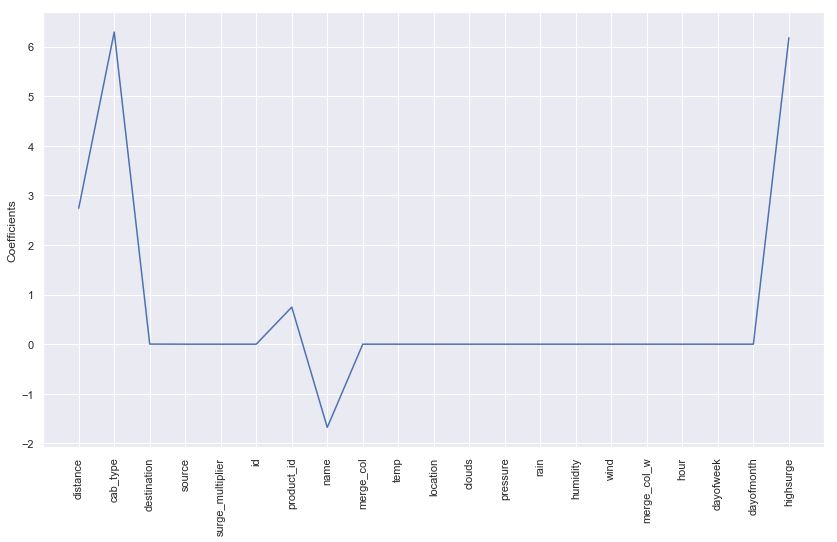

In [134]:
names = merged_df_notnull.drop('price', axis=1).columns
X_new = merged_df_notnull.drop('price', axis=1).values
y_new = merged_df_notnull['price'].values
lasso_regressor(X_new, y_new, names)

In [135]:
X = merged_df_notnull.drop('price', axis=1).values
y = merged_df_notnull['price'].values

rf = random_forest_regressor(X,y)
importances_rf = pd.Series(rf.feature_importances_, index=merged_df_notnull.drop('price', axis=1).columns)

sorted_importances_rf = importances_rf.sort_values()

sorted_importances_rf.plot(kind='barh', color='lightgreen')

plt.show()

KeyboardInterrupt: 

In [ ]:
X = merged_df_notnull[['distance','surge_multiplier','hour']].values
y = merged_df_notnull[['price']].values

In [138]:
def perform_grid_search_cv(grid_dt, X_train, X_test, y_train, y_test):
    grid_dt.fit(X_train, y_train)
    best_hyperparams = grid_dt.best_params_
    best_cv_score = grid_dt.best_score_
    best_model = grid_dt.best_estimator_ 
    test_acc = best_model.score(X_test, y_test)
    print(best_hyperparams)
    print(best_cv_score)
    print(best_model)
    print(test_acc)

In [136]:
gbt = GradientBoostingRegressor(random_state=21)
params_dt = {
    'n_estimators': [100,300,500,700],
    'min_samples_leaf': [3, 4, 6, 8],
    'max_depth':[3,4,5,6],
    'learning_rate': [0.10,0.5,0, 0.0012]
}


grid_dt = GridSearchCV(estimator=gbt,
                       param_grid=params_dt,
                       scoring='r2',
                       cv=10,
                       n_jobs=-1
                      )



X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3, 
                                                    random_state=1)

In [139]:
perform_grid_search_cv(grid_dt, X_train, X_test, y_train, y_test)

KeyboardInterrupt: 

In [140]:
rf = RandomForestRegressor(random_state=21)

params_dt = {
    'n_estimators': [100,300,500,700],
    'min_samples_leaf': [0.04, 0.06, 0.08]
}


grid_dt = GridSearchCV(estimator=rf,
                       param_grid=params_dt,
                       scoring='r2',
                       cv=10,
                       n_jobs=1
                      )



X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3, 
                                                    random_state=1)

perform_grid_search_cv(grid_dt, X_train, X_test, y_train, y_test)


KeyboardInterrupt: 

In [ ]:
dt = DecisionTreeRegressor(random_state=1)

params_dt = {
    'max_depth':[3,4,5,6],
    'min_samples_leaf': [0.04, 0.06, 0.08],
    'max_features':[0.2,0.4,0.6,0.8]
}


grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='r2',
                       cv=10,
                       n_jobs=1
                      )


X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3, 
                                                    random_state=1)

perform_grid_search_cv(grid_dt, X_train, X_test, y_train, y_test)

In [ ]:
X = merged_df_notnull[['distance','surge_multiplier','hour']].values
y = merged_df_notnull[['price']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)